In [5]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import os
import random 
from tensorflow.keras.preprocessing import image
from gensim.models import Word2Vec
import tensorflow_hub as hub  
from sentence_transformers import SentenceTransformer  
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score

/home/noureddine/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
import os

# Créer un dossier local si nécessaire
nltk_data_path = os.path.join(os.getcwd(), "nltk_data")
os.makedirs(nltk_data_path, exist_ok=True)

# Télécharger les ressources nécessaires dans ce dossier
nltk.download('punkt', download_dir=nltk_data_path)
nltk.download('wordnet', download_dir=nltk_data_path)
nltk.download('stopwords', download_dir=nltk_data_path)
nltk.download('omw-1.4', download_dir=nltk_data_path)

# Forcer nltk à utiliser ce dossier
nltk.data.path.append(nltk_data_path)


[nltk_data] Downloading package punkt to
[nltk_data]     /home/noureddine/Documents/noureddine/NY_P6_classifiez
[nltk_data]     -automatiquement-des-biens-de-consommation-1_2025-03-
[nltk_data]     19T082926/YAMOUN_Noureddine_Classifiez automatiquement
[nltk_data]     des biens de consommation/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/noureddine/Documents/noureddine/NY_P6_classifiez
[nltk_data]     -automatiquement-des-biens-de-consommation-1_2025-03-
[nltk_data]     19T082926/YAMOUN_Noureddine_Classifiez automatiquement
[nltk_data]     des biens de consommation/nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/noureddine/Documents/noureddine/NY_P6_classifiez
[nltk_data]     -automatiquement-des-biens-de-consommation-1_2025-03-
[nltk_data]     19T082926/YAMOUN_Noureddine_Classifiez automatiquement
[nltk_data]     des biens de consommation/nltk_data...
[nltk_data]   Unzipping 

In [7]:
import tensorflow as tf
print("TensorFlow détecte le GPU :", tf.config.list_physical_devices('GPU'))

TensorFlow détecte le GPU : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# ETAPE 1 : Étudier la faisabilité de classification en utilisant le NLP basique

#### Charger les données 

In [8]:
# 1. Charger les données
df = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [9]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [11]:
# 1. Charger les données
data = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [12]:
# Concaténer 'product_name' et 'description' pour améliorer les embeddings
df['combined_text'] = df['product_name'] + " " + df['description']

# Vérification
df[['product_name', 'description', 'combined_text']].head()

,product_name,description,combined_text
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Elegance Polyester Multicolor Abstract Eyelet ...
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas Cotton Bath Towel Specifications of S...
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,Eurospa Cotton Terry Face Towel Set Key Featur...
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,SANTOSH ROYAL FASHION Cotton Printed King size...
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,Jaipur Print Cotton Floral King sized Double B...


#### Prétraitement du texte

In [13]:
# Mots inutiles spécifiques à retirer
useless_words = set(["for", "only", "products", "free", "replacement", "delivery",
                 "shipping", "cash", "guarantee", "online", "the", "price",
                 "type", "general", "sales", "warranty", "quality", "details",
                 "brand", "product", "best", "prices", "features", "great",
                 "made", "perfect", "this", "and", "with", "ideal", "buy",
                 "discounts", "also", "yes", "use", "one", "name", "flipkartcom"])

# Phrases inutiles à supprimer
headings = ["Flipkart.com:", "Flipkart.com is offering ", "Buy ",
            "Specifications of ", "Key Features of "]

### Fonction de nettoyage
def preprocess_text(text, mode="Lemmatization"):
    if not isinstance(text, str):
        return ""  # Gérer les valeurs manquantes

    # Suppression des en-têtes inutiles
    for header in headings:
        text = text.replace(header, "")

    # Mise en minuscules
    text = text.lower()

    # Suppression des chiffres
    text = re.sub(r'\d+', '', text)

    # Suppression des caractères spéciaux (en gardant espaces et lettres)
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenisation
    word_tokens = word_tokenize(text)

    # Suppression des stopwords et mots inutiles spécifiques
    filtered_words = [word for word in word_tokens if word not in stop_words and word not in useless_words and len(word) > 2]

    # Choix entre Lemmatization et Stemming
    if mode == "Lemmatization":
        processed_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    elif mode == "Stemming":
        processed_words = [stemmer.stem(word) for word in filtered_words]
    else:
        processed_words = filtered_words  
    return ' '.join(processed_words)


#### Extraction des features : Bag of Words et TF-IDF

In [33]:
import nltk
import os

# 1. Chemin local vers nltk_data
nltk_data_path = os.path.join(os.getcwd(), "nltk_data")
os.makedirs(nltk_data_path, exist_ok=True)

# 2. Téléchargement dans ce dossier local
nltk.download('punkt', download_dir=nltk_data_path)
nltk.download('wordnet', download_dir=nltk_data_path)
nltk.download('stopwords', download_dir=nltk_data_path)
nltk.download('omw-1.4', download_dir=nltk_data_path)

# 3. Ajout du chemin dans les paths que NLTK utilise
nltk.data.path.append(nltk_data_path)


[nltk_data] Downloading package punkt to
[nltk_data]     /home/noureddine/Documents/noureddine/NY_P6_classifiez
[nltk_data]     -automatiquement-des-biens-de-consommation-1_2025-03-
[nltk_data]     19T082926/YAMOUN_Noureddine_Classifiez automatiquement
[nltk_data]     des biens de consommation/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/noureddine/Documents/noureddine/NY_P6_classifiez
[nltk_data]     -automatiquement-des-biens-de-consommation-1_2025-03-
[nltk_data]     19T082926/YAMOUN_Noureddine_Classifiez automatiquement
[nltk_data]     des biens de consommation/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/noureddine/Documents/noureddine/NY_P6_classifiez
[nltk_data]     -automatiquement-des-biens-de-consommation-1_2025-03-
[nltk_data]     19T082926/YAMOUN_Noureddine_Classifiez automatiquement
[nltk_data]     des b

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, mode="Lemmatization"):
    # Nettoyage de base
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Supprimer les chiffres
    text = re.sub(r'[^\w\s]', '', text)  # Supprimer la ponctuation

    # Tokenisation
    words = word_tokenize(text)

    # Suppression des stopwords
    words = [word for word in words if word not in stop_words]

    if mode == "Lemmatization":
        words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)


In [57]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer

tokenizer = TreebankWordTokenizer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text, mode="Lemmatization"):
    text = text.lower()
    words = tokenizer.tokenize(text)
    words = [word for word in words if word.isalpha() and word not in stop_words]

    if mode == "Lemmatization":
        words = [lemmatizer.lemmatize(word, pos='v') for word in words]
    
    return ' '.join(words)


In [59]:
data['cleaned_text'] = data['description'].apply(lambda x: preprocess_text(x, mode="Lemmatization"))

### Vectorisation
vectorizer_bow = CountVectorizer(max_features=200)  
vectorizer_tfidf = TfidfVectorizer(max_features=500)

bow_features = vectorizer_bow.fit_transform(data['cleaned_text']).toarray()
tfidf_features = vectorizer_tfidf.fit_transform(data['cleaned_text']).toarray()

In [60]:
###  Universal Sentence Encoder (USE)

def use_embedding(sentences):
    with tf.device('/CPU:0'):  # forcer le CPU
        model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
        return model(sentences).numpy()
    
use_vectors = use_embedding(data['description'])

 # Transformation en numpy array 
use_features = np.array(use_vectors) 

In [73]:
# Tokenisation des descriptions
data['tokenized_text'] = data['description'].apply(lambda x: x.split())

# Entraînement du modèle Word2Vec
word2vec_model = Word2Vec(sentences=data['tokenized_text'], vector_size=100, window=5, min_count=1, workers=4)

# Création des vecteurs Word2Vec (moyenne des mots pour chaque description)
def get_sentence_vector(sentence):
    words = sentence.split()
    word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(100)

# Application de la fonction get_sentence_vector pour transformer chaque texte en vecteur Word2Vec
word2vec_features = np.vstack(data['description'].apply(get_sentence_vector))
len(word2vec_features)

1050

In [62]:
###  BERT Embeddings

def bert_embedding(sentences):
    # Charger le modèle BERT pré-entraîné (de Sentence Transformers)
    model = SentenceTransformer('bert-base-nli-mean-tokens')
    return model.encode(sentences)

bert_vectors = bert_embedding(data['description'])
bert_features = np.array(bert_vectors)  
len(bert_features)

1050

In [64]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_bow = CountVectorizer(max_features=500)
bow_features = vectorizer_bow.fit_transform(data['cleaned_text']).toarray()

vectorizer_tfidf = TfidfVectorizer(max_features=500)
tfidf_features = vectorizer_tfidf.fit_transform(data['cleaned_text']).toarray()


In [65]:
import numpy as np

# Définir la proportion d'échantillonnage
sample_fraction = 0.5  # 50% des données
sample_size = int(sample_fraction * len(data))  # Calculer la taille de l'échantillon

# Générer un échantillon aléatoire des indices
sample_indices = np.random.choice(len(data), size=sample_size, replace=False)

# Sous-échantillonnage des features
bow_sample = bow_features[sample_indices]
tfidf_sample = tfidf_features[sample_indices]
use_sample = use_features[sample_indices]
word2vec_sample = word2vec_features[sample_indices]
bert_sample = bert_features[sample_indices]

In [66]:
def elbow_method(features, method_name, max_clusters=16):
    inertia = []
    k_range = range(2, max_clusters+1)  # Tester différents nombres de clusters
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(features)
        inertia.append(kmeans.inertia_)  # Stocker l'inertie

    # Tracer le graphique du coude
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, inertia, marker='o', linestyle='--')
    plt.xlabel('Nombre de clusters K')
    plt.ylabel('Inertie')
    plt.title(f'Méthode du Coude - {method_name}')
    plt.show()

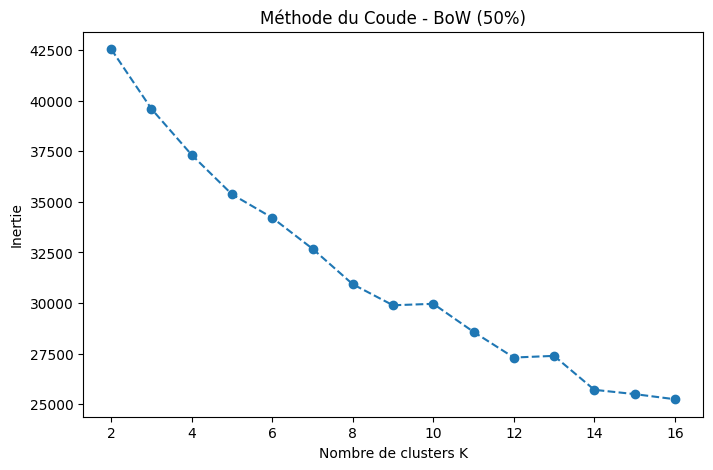

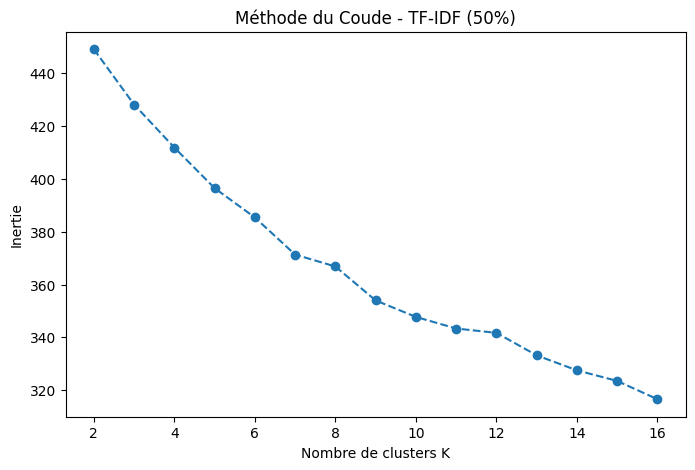

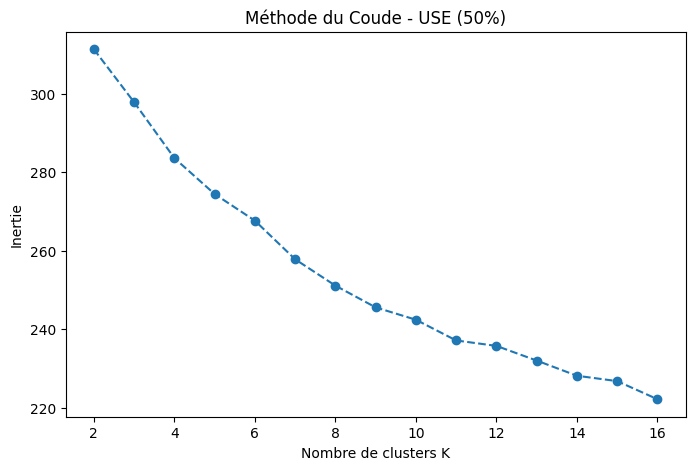

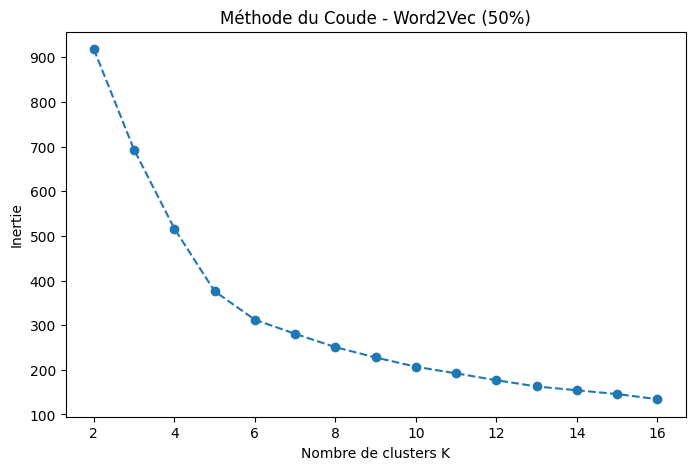

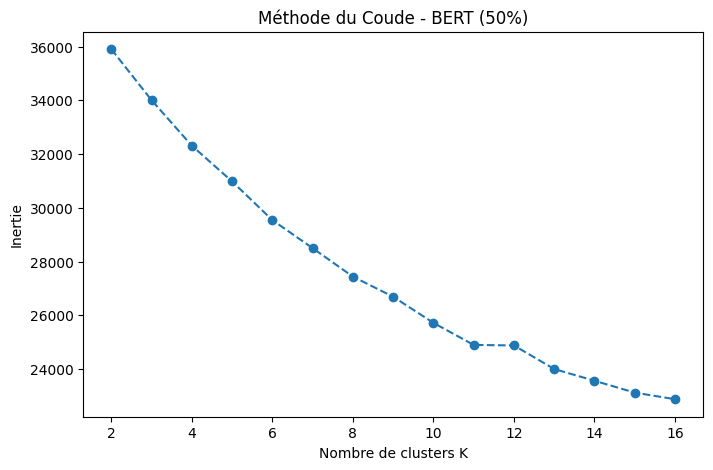

In [70]:
from sklearn.cluster import KMeans

# Appliquer la méthode du coude pour chaque représentation avec l'échantillon
elbow_method(bow_sample, "BoW (50%)")
elbow_method(tfidf_sample, "TF-IDF (50%)")
elbow_method(use_sample, "USE (50%)")
elbow_method(word2vec_sample, "Word2Vec (50%)")
elbow_method(bert_sample, "BERT (50%)")

### Entrainer un modele K-means pour K = 7

In [75]:
from sklearn.metrics import adjusted_rand_score

# Fonction pour exécuter K-Means et calculer l'ARI
def evaluate_kmeans(features, true_labels, k_values=[7, 10]):
    results = {}
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(features)
        ari_score = adjusted_rand_score(true_labels, cluster_labels)
        results[k] = ari_score
        print(f"ARI Score for K={k}: {ari_score:.2f}")
    return results

# Exécution sur les différentes représentations des textes
true_labels = LabelEncoder().fit_transform(data['product_category_tree'])

print("\nEvaluating K-Means on different embeddings:\n")

ari_results = {
    "BoW": evaluate_kmeans(bow_features, true_labels),
    "TF-IDF": evaluate_kmeans(tfidf_features, true_labels),
    "USE": evaluate_kmeans(use_vectors, true_labels),
    "Word2Vec": evaluate_kmeans(word2vec_features, true_labels),
    "BERT": evaluate_kmeans(bert_vectors, true_labels)
}

ari_df = pd.DataFrame(ari_results)
ari_df


Evaluating K-Means on different embeddings:

ARI Score for K=7: 0.01
ARI Score for K=10: 0.02
ARI Score for K=7: 0.03
ARI Score for K=10: 0.05
ARI Score for K=7: 0.04
ARI Score for K=10: 0.07
ARI Score for K=7: 0.04
ARI Score for K=10: 0.06
ARI Score for K=7: 0.03
ARI Score for K=10: 0.05


,BoW,TF-IDF,USE,Word2Vec,BERT
7,0.014465,0.032192,0.039314,0.040883,0.034730
10,0.018234,0.047533,0.065354,0.060097,0.054728


In [76]:
from sklearn.metrics import silhouette_score

# Liste des embeddings à tester
embedding_dict = {
    "BoW": bow_features,
    "TF-IDF": tfidf_features,
    "USE": use_vectors,
    "Word2Vec": word2vec_features,
    "BERT": bert_vectors
}

# Nombre de clusters à tester
k_values = [8, 10]

# Dictionnaire pour stocker les scores de silhouette
silhouette_scores = {}

# Boucle sur chaque embedding et chaque valeur de K
for k in k_values:
    silhouette_scores[k] = {}
    for name, features in embedding_dict.items():
        # Application de KMeans
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(features)
        
        # Calcul du silhouette score
        score = silhouette_score(features, cluster_labels)
        silhouette_scores[k][name] = score

silhouette_df = pd.DataFrame(silhouette_scores)
silhouette_df

,8,10
BoW,0.288445,0.109437
TF-IDF,0.120777,0.129611
USE,0.103393,0.114961
Word2Vec,0.429505,0.385163
BERT,0.168664,0.151875


## tsne avec 7 clusters

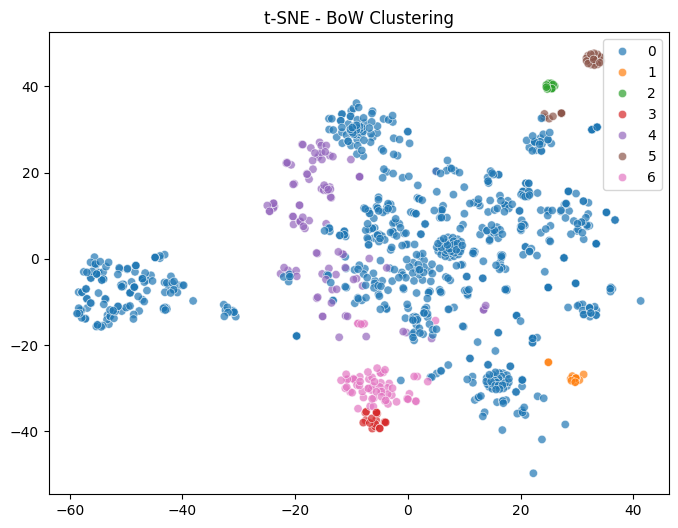

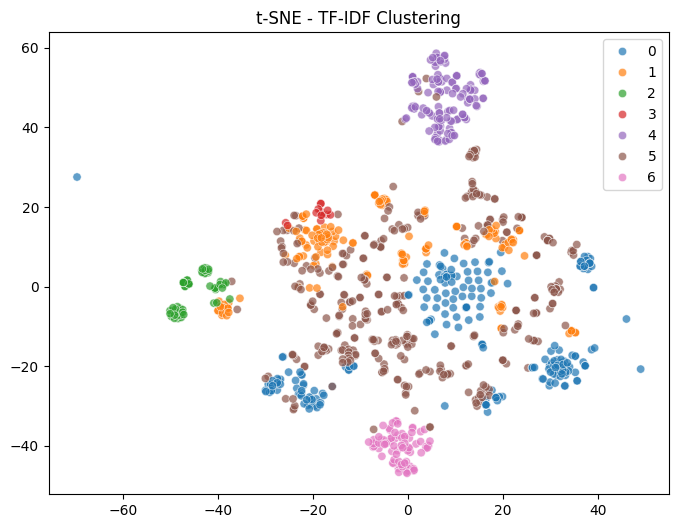

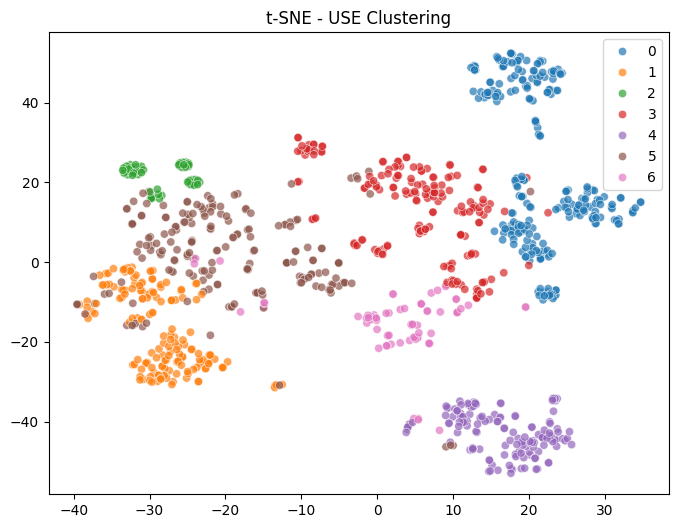

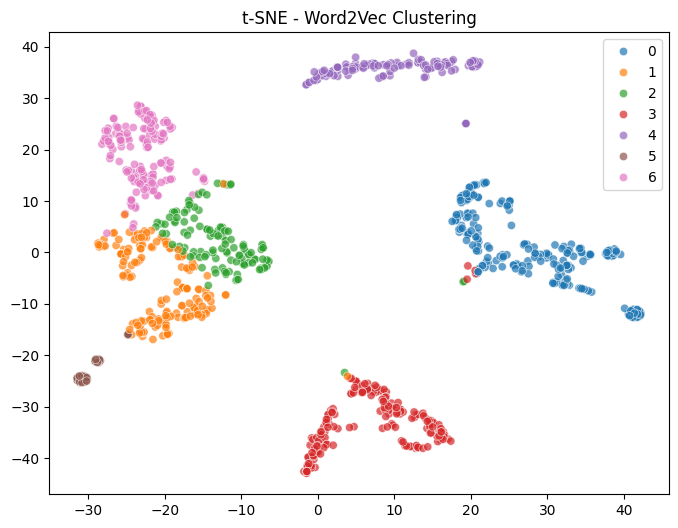

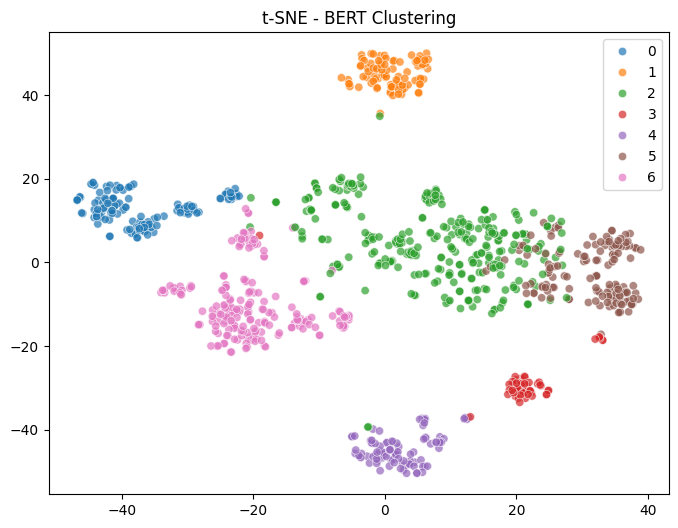

In [78]:
# Fonction pour afficher t-SNE avec clustering
def plot_tsne_with_clusters(features, labels, title):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced_features = tsne.fit_transform(features)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=reduced_features[:, 0],
        y=reduced_features[:, 1],
        hue=labels,
        palette="tab10",
        alpha=0.7
    )
    plt.title(title)
    plt.show()

# Déterminer le nombre optimal de clusters 
k = 7

# Appliquer K-Means sur chaque représentation et récupérer les labels
kmeans_bow = KMeans(n_clusters=k, random_state=42).fit(bow_features)
kmeans_tfidf = KMeans(n_clusters=k, random_state=42).fit(tfidf_features)
kmeans_use = KMeans(n_clusters=k, random_state=42).fit(use_vectors)
kmeans_w2v = KMeans(n_clusters=k, random_state=42).fit(word2vec_features)
kmeans_bert = KMeans(n_clusters=k, random_state=42).fit(bert_vectors)

# Affichage des graphes t-SNE avec clustering
plot_tsne_with_clusters(bow_features, kmeans_bow.labels_, "t-SNE - BoW Clustering")
plot_tsne_with_clusters(tfidf_features, kmeans_tfidf.labels_, "t-SNE - TF-IDF Clustering")
plot_tsne_with_clusters(use_vectors, kmeans_use.labels_, "t-SNE - USE Clustering")
plot_tsne_with_clusters(word2vec_features, kmeans_w2v.labels_, "t-SNE - Word2Vec Clustering")
plot_tsne_with_clusters(bert_vectors, kmeans_bert.labels_, "t-SNE - BERT Clustering")


### Afficher Tsne avec les vrais labels

In [79]:
def extract_first_category(category_tree):
    """Extrait la première catégorie de la hiérarchie du product_category_tree"""
    try:
        return eval(category_tree)[0].split(" >> ")[0]  # Convertir la string en liste et prendre le premier élément
    except:
        return "Unknown"

# Appliquer la fonction
data['main_category'] = data['product_category_tree'].apply(extract_first_category)

In [80]:
print(data['main_category'].value_counts())

main_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64


In [81]:
top_categories = data['main_category'].value_counts()

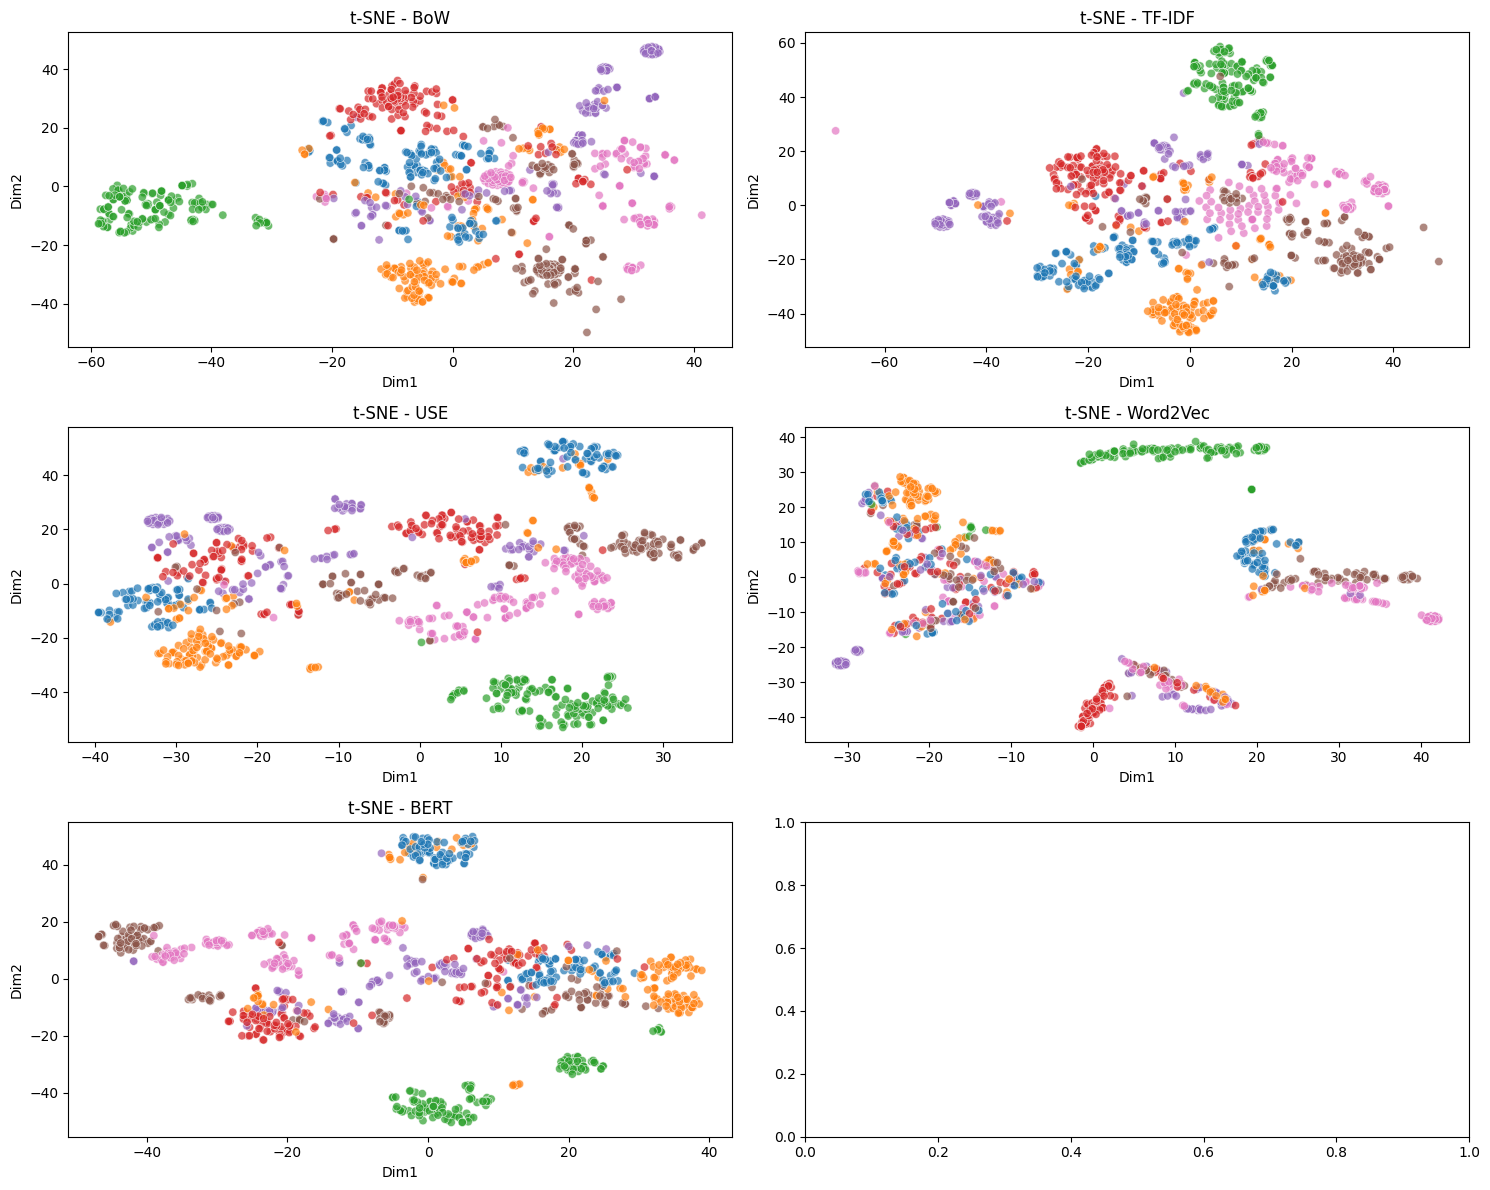

In [83]:
# Dictionnaire contenant les embeddings
embeddings_dict = {
    "BoW": bow_features,
    "TF-IDF": tfidf_features,
    "USE": use_vectors,
    "Word2Vec": word2vec_features,
    "BERT": bert_vectors
}

# Encoder les catégories pour assigner des couleurs
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['encoded_category'] = label_encoder.fit_transform(data['main_category'])

# Création des visualisations t-SNE
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, (name, features) in enumerate(embeddings_dict.items()):
    # Réduction avec t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced_features = tsne.fit_transform(features)

    # Création du DataFrame pour visualisation
    tsne_df = pd.DataFrame(reduced_features, columns=['Dim1', 'Dim2'])
    tsne_df['category'] = data['main_category']

    # Tracé du graphique
    sns.scatterplot(x='Dim1', y='Dim2', hue='category', palette='tab10', data=tsne_df, alpha=0.7, ax=axes[i])
    axes[i].set_title(f't-SNE - {name}')
    axes[i].legend([],[], frameon=False)  # Cacher la légende pour éviter la surcharge

plt.tight_layout()
plt.show()

# Étape 3 : Étudier la faisabilité de classification en utilisant des techniques de traitement d’image basiques (J'ai fais lentrainement ici et sift mais les détails sont dans l'autre netebook)

#### Prétraitement des images

def get_image_files(directory):
    image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp'}
    return [f for f in os.listdir(directory) if os.path.splitext(f)[1].lower() in image_extensions]

def select_images(lst):
    selected = lst[0:50] if len(lst) > 50 else lst
    lst = lst[50:] if len(lst) > 50 else lst
    return selected, lst


##### Analysez les images via différentes méthodes de transformation (niveau de gris, filtrage bruit, contraste etc.).

In [ ]:
# Fonction pour récupérer tous les fichiers image dans un dossier
def get_image_files(image_folder):
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')  # Extensions valides
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(valid_extensions)]
    return image_files

def select_images(images):
    return images[:50], images[50:]

In [70]:
images = get_image_files('Images')
current_images, lst_images_names = select_images(images)

# Vue les données volumineux, j'ai préférer de traiter par 50 images a la fois, comme c'est que de l'analyse  
def analyse_images(lst_names):
    for img_path in lst_names:
        img_path = "Images/"+img_path
        image = cv2.imread(img_path)
        
        # Vérifier si l'image a été chargée
        if image is None:
            print(f"Erreur: Impossible de charger l'image {img_path}")
            continue
        
        # 1. Conversion en niveaux de gris
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # 2. Filtrage du bruit : appliquer un filtre gaussien
        gaussian_blur = cv2.GaussianBlur(gray, (5, 5), 0)
        
        # 3. Ajustement du contraste : égalisation d'histogramme sur l'image en niveaux de grisF
        equalized = cv2.equalizeHist(gaussian_blur)
        


analyse_images(current_images)

##### Utilisez des algorithmes d'extraction d'e features d’images comme SIFT

In [72]:
# Configuration
image_folder = "Images"
IMAGE_SIZE = (128, 128)  # Taille réduite pour accélérer le traitement
NUM_SAMPLES = 1050  # Nombre d'images traitées
MAX_SIFT_FEATURES = 100  # Limite de points clés pour éviter les matrices trop grandes

# Liste des fichiers images et sélection aléatoire
image_names = os.listdir(image_folder)
selected_images = random.sample(image_names, min(NUM_SAMPLES, len(image_names)))  # Sélection aléatoire

# Charger et prétraiter une image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None

    # Redimensionner pour normaliser la taille
    image = cv2.resize(image, IMAGE_SIZE)

    # Conversion en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Réduction du bruit avec un flou gaussien
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Augmentation du contraste avec equalisation d’histogramme
    enhanced = cv2.equalizeHist(blurred)

    return enhanced

# Extraction des features avec SIFT
def extract_sift_features(image):
    sift = cv2.SIFT_create(nfeatures=MAX_SIFT_FEATURES)  # Limitation des points clés détectés
    keypoints, descriptors = sift.detectAndCompute(image, None)

    # Vérifier si des descripteurs sont extraits
    if descriptors is None:
        return np.zeros((MAX_SIFT_FEATURES, 128))  # Remplissage si aucune feature

    # S'assurer que la dimension des features est fixe
    if descriptors.shape[0] < MAX_SIFT_FEATURES:
        padding = np.zeros((MAX_SIFT_FEATURES - descriptors.shape[0], 128))
        descriptors = np.vstack((descriptors, padding))
    
    return descriptors.flatten()  # Aplatir en 1D pour standardiser



In [75]:
# Initialisation des résultats
image_features = []
image_labels = []

# Traitement des images sélectionnées
for idx, image_name in enumerate(selected_images):
    image_path = os.path.join(image_folder, image_name)
    processed_image = preprocess_image(image_path)

    if processed_image is not None:
        features = extract_sift_features(processed_image)
        image_features.append(features)
        image_labels.append(image_name)

    # Affichage de la progression toutes les 50 images
    if idx % 50 == 0:
        print(f"Traitement {idx+1}/{len(selected_images)} images...")

# Convertir en DataFrame
df_features = pd.DataFrame(image_features)
df_features['category'] = image_labels  


print(f"Nombre total de NaN dans df_features: {df_features.isna().sum().sum() }")
df_features = df_features.fillna(0)
print(f"Nombre total de NaN aprés traitement dans df_features: {df_features.isna().sum().sum() }")


Traitement 1/1050 images...
Traitement 51/1050 images...
Traitement 101/1050 images...
Traitement 151/1050 images...
Traitement 201/1050 images...
Traitement 251/1050 images...
Traitement 301/1050 images...
Traitement 351/1050 images...
Traitement 401/1050 images...
Traitement 451/1050 images...
Traitement 501/1050 images...
Traitement 551/1050 images...
Traitement 601/1050 images...
Traitement 651/1050 images...
Traitement 701/1050 images...
Traitement 751/1050 images...
Traitement 801/1050 images...
Traitement 851/1050 images...
Traitement 901/1050 images...
Traitement 951/1050 images...
Traitement 1001/1050 images...
Nombre total de NaN dans df_features: 388992
Nombre total de NaN aprés traitement dans df_features: 0


##### Utilisez des méthodes de réduction de dimension sur les images encodées et comparer les résultats avec les catégories réelles. 

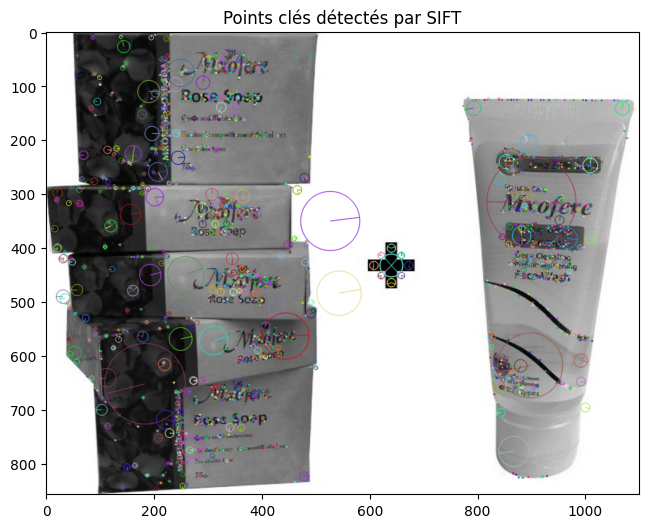

In [80]:
# Charger l'image
image_path = "Images/00d84a518e0550612fcfcba3b02b6255.jpg"
image_ = cv2.imread(image_path)

# Conversion en niveaux de gris
gray = cv2.cvtColor(image_, cv2.COLOR_BGR2GRAY)

# Appliquer SIFT
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(gray, None)

# Dessiner les points d'intérêt sur l'image
sift_image = cv2.drawKeypoints(gray, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Afficher l'image avec les keypoints
plt.figure(figsize=(8,6))
plt.imshow(sift_image, cmap='gray')
plt.title("Points clés détectés par SIFT")
plt.show()


# PARTIE 2 :

# ETAPE 1

##### augmentation de données

In [94]:
# 1. Charger les données
df = pd.read_csv('categories.csv')

In [95]:
df.head()

,image_name,category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"[""Home Furnishing"
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,"[""Baby Care"
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,"[""Baby Care"
3,d4684dcdc759dd9cdf41504698d737d8.jpg,"[""Home Furnishing"
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,"[""Home Furnishing"


In [96]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [97]:
# Ajouter le chemin complet aux images
df["image_path"] = df["image_name"].apply(lambda x: os.path.join("Images", x))

In [98]:
df.head()

,image_name,category,image_path
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"[""Home Furnishing",Images\55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,"[""Baby Care",Images\7b72c92c2f6c40268628ec5f14c6d590.jpg
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,"[""Baby Care",Images\64d5d4a258243731dc7bbb1eef49ad74.jpg
3,d4684dcdc759dd9cdf41504698d737d8.jpg,"[""Home Furnishing",Images\d4684dcdc759dd9cdf41504698d737d8.jpg
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,"[""Home Furnishing",Images\6325b6870c54cd47be6ebfbffa620ec7.jpg


In [99]:
from sklearn.model_selection import train_test_split

# Séparer le dataset en Train (70%), Validation (15%) et Test (15%)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["category"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["category"])

# Vérifier la répartition
print(f"Train: {len(train_df)} images, Validation: {len(val_df)} images, Test: {len(test_df)} images")

Train: 735 images, Validation: 157 images, Test: 158 images


##### Création du modele

In [101]:
batch_size = 32  # Nombre d'images par batch

# Fonction pour créer un data generator
def data_flow_fct(data, datagen, data_type=None):
    return datagen.flow_from_dataframe(
        dataframe=data,
        x_col="image_path",  # Chemin des images
        y_col="category",  # Labels
        target_size=(224, 224),  # Taille standardisée des images
        class_mode="categorical",  # Classification multi-classes
        batch_size=batch_size,
        shuffle=True,  # Mélanger les images
        seed=42,
        subset=data_type  # "training", "validation" ou None
    )

# Data Augmentation pour l'entraînement
datagen_train = ImageDataGenerator(
    rescale=1./255,  # Normalisation des pixels entre 0 et 1
    rotation_range=20,  # Rotation aléatoire
    width_shift_range=0.2,  # Décalage horizontal
    height_shift_range=0.2,  # Décalage vertical
    shear_range=0.2,  # Transformation affine
    zoom_range=0.2,  # Zoom aléatoire
    horizontal_flip=True,  # Miroir horizontal
    fill_mode="nearest",  # Remplissage des pixels
    validation_split=0.25  # 25% des images seront utilisées pour la validation
)

# Générer les images pour l'entraînement et la validation
train_flow = data_flow_fct(train_df, datagen_train, data_type="training")
val_flow = data_flow_fct(val_df, datagen_train, data_type="validation")

# Générer les images pour le test (sans augmentation)
datagen_test = ImageDataGenerator(rescale=1./255)  # Juste la normalisation
test_flow = data_flow_fct(test_df, datagen_test, data_type=None)


Found 552 validated image filenames belonging to 7 classes.
Found 39 validated image filenames belonging to 7 classes.
Found 158 validated image filenames belonging to 7 classes.


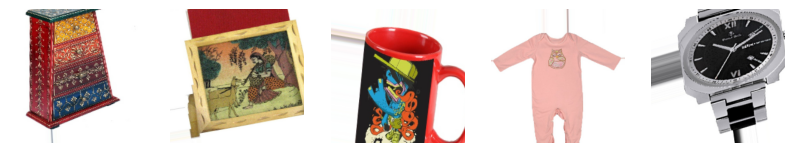

In [102]:
import matplotlib.pyplot as plt

# Extraire un batch d'images augmentées
x_batch, y_batch = next(train_flow)

# Afficher les premières images transformées
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_batch[i])  # Affichage des images augmentées
    plt.axis("off")
plt.show()


##### Creation du modele

In [107]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Charger le modèle VGG16 pré-entraîné sans la dernière couche fully connected
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

#Débloquer les dernières couches de VGG16
for layer in base_model.layers[-4:]:  # Débloquer 4 dernières couches
    layer.trainable = True

# Ajouter de nouvelles couches adaptées aux dataset (7 classes)
x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dense(256, activation="relu")(x)  
x = Dropout(0.5)(x)  
x = Dense(128, activation="relu")(x)  
x = Dropout(0.5)(x)  
output_layer = Dense(7, activation="softmax")(x)  

# Création du nouveau modèle
model = Model(inputs=base_model.input, outputs=output_layer)

# Compilation du modèle
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Réduire le learning rate
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Vérifier que le modèle est bien mis à jour
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,3

 Total params: 14,879,815 (56.76 MB)

 Trainable params: 14,879,815 (56.76 MB)

 Non-trainable params: 0 (0.00 B)

In [117]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Création du callback ModelCheckpoint
checkpoint = ModelCheckpoint(
    "best_model.h5",  # Sauvegarde du meilleur modèle
    monitor="val_loss",  # Surveiller la perte sur validation
    save_best_only=True,  # Sauvegarde uniquement le meilleur modèle
    mode="min",  # On cherche à minimiser la val_loss
    verbose=1
)

# Ensuite, relancer l'entraînement avec ce callback
history = model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=100,
    callbacks=[checkpoint],  
    verbose=1
)

C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.1554 - loss: 2.2142
Epoch 1: val_loss improved from inf to 1.94148, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 404s 12s/step - accuracy: 0.1552 - loss: 2.2125 - val_accuracy: 0.2051 - val_loss: 1.9415
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.1371 - loss: 2.1242
Epoch 2: val_loss improved from 1.94148 to 1.90977, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 170s 9s/step - accuracy: 0.1382 - loss: 2.1206 - val_accuracy: 0.2308 - val_loss: 1.9098
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.1297 - loss: 2.0163
Epoch 3: val_loss improved from 1.90977 to 1.86795, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 176s 10s/step - accuracy: 0.1310 - loss: 2.0152 - val_accuracy: 0.3077 - val_loss: 1.8680
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.1495 - loss: 1.9717
Epoch 4: val_loss improved from 1.86795 to 1.84348, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 172s 10s/step - accuracy: 0.1514 - loss: 1.9711 - val_accuracy: 0.2821 - val_loss: 1.8435
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2105 - loss: 1.8775
Epoch 5: val_loss improved from 1.84348 to 1.79692, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 174s 10s/step - accuracy: 0.2114 - loss: 1.8767 - val_accuracy: 0.2821 - val_loss: 1.7969
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2495 - loss: 1.8906
Epoch 6: val_loss improved from 1.79692 to 1.75969, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 175s 10s/step - accuracy: 0.2506 - loss: 1.8890 - val_accuracy: 0.3333 - val_loss: 1.7597
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2634 - loss: 1.8022
Epoch 7: val_loss improved from 1.75969 to 1.66400, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 177s 10s/step - accuracy: 0.2645 - loss: 1.8016 - val_accuracy: 0.3590 - val_loss: 1.6640
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3106 - loss: 1.7477
Epoch 8: val_loss improved from 1.66400 to 1.65992, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 177s 10s/step - accuracy: 0.3109 - loss: 1.7481 - val_accuracy: 0.4103 - val_loss: 1.6599
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3426 - loss: 1.7102
Epoch 9: val_loss improved from 1.65992 to 1.57634, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 175s 10s/step - accuracy: 0.3430 - loss: 1.7107 - val_accuracy: 0.5385 - val_loss: 1.5763
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3734 - loss: 1.6706 
Epoch 10: val_loss improved from 1.57634 to 1.42871, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 173s 10s/step - accuracy: 0.3754 - loss: 1.6655 - val_accuracy: 0.4872 - val_loss: 1.4287
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3497 - loss: 1.6574
Epoch 11: val_loss improved from 1.42871 to 1.35284, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 178s 10s/step - accuracy: 0.3526 - loss: 1.6538 - val_accuracy: 0.5385 - val_loss: 1.3528
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4252 - loss: 1.4915
Epoch 12: val_loss improved from 1.35284 to 1.29895, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 176s 10s/step - accuracy: 0.4251 - loss: 1.4924 - val_accuracy: 0.5641 - val_loss: 1.2990
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4188 - loss: 1.4645
Epoch 13: val_loss improved from 1.29895 to 1.28718, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 175s 10s/step - accuracy: 0.4189 - loss: 1.4645 - val_accuracy: 0.6410 - val_loss: 1.2872
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.4634 - loss: 1.4319
Epoch 14: val_loss improved from 1.28718 to 1.27977, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 178s 10s/step - accuracy: 0.4644 - loss: 1.4304 - val_accuracy: 0.6154 - val_loss: 1.2798
Epoch 15/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4581 - loss: 1.4459
Epoch 15: val_loss improved from 1.27977 to 1.18249, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 172s 10s/step - accuracy: 0.4588 - loss: 1.4438 - val_accuracy: 0.7436 - val_loss: 1.1825
Epoch 16/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.4997 - loss: 1.3778
Epoch 16: val_loss did not improve from 1.18249
18/18 ━━━━━━━━━━━━━━━━━━━━ 171s 10s/step - accuracy: 0.4989 - loss: 1.3793 - val_accuracy: 0.6923 - val_loss: 1.2135
Epoch 17/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5455 - loss: 1.3086
Epoch 17: val_loss improved from 1.18249 to 1.13836, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 174s 10s/step - accuracy: 0.5437 - loss: 1.3106 - val_accuracy: 0.6923 - val_loss: 1.1384
Epoch 18/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5564 - loss: 1.2330
Epoch 18: val_loss did not improve from 1.13836
18/18 ━━━━━━━━━━━━━━━━━━━━ 172s 9s/step - accuracy: 0.5549 - loss: 1.2365 - val_accuracy: 0.6154 - val_loss: 1.1635
Epoch 19/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5164 - loss: 1.2505
Epoch 19: val_loss improved from 1.13836 to 1.13670, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 166s 9s/step - accuracy: 0.5175 - loss: 1.2513 - val_accuracy: 0.5897 - val_loss: 1.1367
Epoch 20/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5504 - loss: 1.2415
Epoch 20: val_loss improved from 1.13670 to 1.12671, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 167s 9s/step - accuracy: 0.5507 - loss: 1.2425 - val_accuracy: 0.6667 - val_loss: 1.1267
Epoch 21/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5885 - loss: 1.1672
Epoch 21: val_loss improved from 1.12671 to 0.96166, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 167s 9s/step - accuracy: 0.5880 - loss: 1.1681 - val_accuracy: 0.7692 - val_loss: 0.9617
Epoch 22/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5399 - loss: 1.3095
Epoch 22: val_loss did not improve from 0.96166
18/18 ━━━━━━━━━━━━━━━━━━━━ 164s 9s/step - accuracy: 0.5397 - loss: 1.3078 - val_accuracy: 0.7692 - val_loss: 1.0195
Epoch 23/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5944 - loss: 1.1312
Epoch 23: val_loss did not improve from 0.96166
18/18 ━━━━━━━━━━━━━━━━━━━━ 165s 9s/step - accuracy: 0.5938 - loss: 1.1322 - val_accuracy: 0.7692 - val_loss: 0.9830
Epoch 24/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5935 - loss: 1.1605
Epoch 24: val_loss improved from 0.96166 to 0.90692, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 165s 9s/step - accuracy: 0.5944 - loss: 1.1571 - val_accuracy: 0.7949 - val_loss: 0.9069
Epoch 25/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5885 - loss: 1.1200
Epoch 25: val_loss did not improve from 0.90692
18/18 ━━━━━━━━━━━━━━━━━━━━ 167s 9s/step - accuracy: 0.5884 - loss: 1.1194 - val_accuracy: 0.8205 - val_loss: 0.9355
Epoch 26/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6319 - loss: 1.0524
Epoch 26: val_loss improved from 0.90692 to 0.89512, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 167s 9s/step - accuracy: 0.6298 - loss: 1.0551 - val_accuracy: 0.7949 - val_loss: 0.8951
Epoch 27/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6331 - loss: 1.0456
Epoch 27: val_loss improved from 0.89512 to 0.86980, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 165s 9s/step - accuracy: 0.6328 - loss: 1.0452 - val_accuracy: 0.8205 - val_loss: 0.8698
Epoch 28/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6105 - loss: 1.1216
Epoch 28: val_loss improved from 0.86980 to 0.85836, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 168s 9s/step - accuracy: 0.6112 - loss: 1.1197 - val_accuracy: 0.7179 - val_loss: 0.8584
Epoch 29/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6192 - loss: 1.0460
Epoch 29: val_loss improved from 0.85836 to 0.83380, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 166s 9s/step - accuracy: 0.6199 - loss: 1.0445 - val_accuracy: 0.7692 - val_loss: 0.8338
Epoch 30/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6702 - loss: 0.9227
Epoch 30: val_loss improved from 0.83380 to 0.77986, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 165s 9s/step - accuracy: 0.6702 - loss: 0.9236 - val_accuracy: 0.7692 - val_loss: 0.7799
Epoch 31/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6551 - loss: 0.9880
Epoch 31: val_loss improved from 0.77986 to 0.75179, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 169s 9s/step - accuracy: 0.6552 - loss: 0.9895 - val_accuracy: 0.8205 - val_loss: 0.7518
Epoch 32/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6797 - loss: 0.9062
Epoch 32: val_loss did not improve from 0.75179
18/18 ━━━━━━━━━━━━━━━━━━━━ 165s 9s/step - accuracy: 0.6791 - loss: 0.9085 - val_accuracy: 0.7436 - val_loss: 0.7948
Epoch 33/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7096 - loss: 0.8676
Epoch 33: val_loss did not improve from 0.75179
18/18 ━━━━━━━━━━━━━━━━━━━━ 165s 9s/step - accuracy: 0.7096 - loss: 0.8687 - val_accuracy: 0.7692 - val_loss: 0.8270
Epoch 34/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6663 - loss: 0.9048
Epoch 34: val_loss did not improve from 0.75179
18/18 ━━━━━━━━━━━━━━━━━━━━ 165s 9s/step - accuracy: 0.6662 - loss: 0.9051 - val_accuracy: 0.7436 - val_loss: 0.7624
Epoch 35/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6359 - loss: 0.9161
Epoch 35: val_loss did not improve from 0.75179
18/1

18/18 ━━━━━━━━━━━━━━━━━━━━ 166s 9s/step - accuracy: 0.6687 - loss: 0.8940 - val_accuracy: 0.7692 - val_loss: 0.7046
Epoch 37/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7055 - loss: 0.8552
Epoch 37: val_loss did not improve from 0.70458
18/18 ━━━━━━━━━━━━━━━━━━━━ 165s 9s/step - accuracy: 0.7065 - loss: 0.8525 - val_accuracy: 0.7692 - val_loss: 0.7388
Epoch 38/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6683 - loss: 0.8865
Epoch 38: val_loss did not improve from 0.70458
18/18 ━━━━━━━━━━━━━━━━━━━━ 164s 9s/step - accuracy: 0.6698 - loss: 0.8836 - val_accuracy: 0.7692 - val_loss: 0.7466
Epoch 39/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7254 - loss: 0.8122
Epoch 39: val_loss did not improve from 0.70458
18/18 ━━━━━━━━━━━━━━━━━━━━ 169s 9s/step - accuracy: 0.7260 - loss: 0.8104 - val_accuracy: 0.7949 - val_loss: 0.7337
Epoch 40/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7162 - loss: 0.7851
Epoch 40: val_loss did not improve from 0.70458
18/1

18/18 ━━━━━━━━━━━━━━━━━━━━ 166s 9s/step - accuracy: 0.7549 - loss: 0.8040 - val_accuracy: 0.8205 - val_loss: 0.6323
Epoch 43/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7690 - loss: 0.7238
Epoch 43: val_loss did not improve from 0.63227
18/18 ━━━━━━━━━━━━━━━━━━━━ 163s 9s/step - accuracy: 0.7687 - loss: 0.7246 - val_accuracy: 0.7949 - val_loss: 0.6906
Epoch 44/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8143 - loss: 0.6149
Epoch 44: val_loss did not improve from 0.63227
18/18 ━━━━━━━━━━━━━━━━━━━━ 162s 9s/step - accuracy: 0.8126 - loss: 0.6167 - val_accuracy: 0.8718 - val_loss: 0.6861
Epoch 45/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7669 - loss: 0.7770
Epoch 45: val_loss improved from 0.63227 to 0.61107, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 163s 9s/step - accuracy: 0.7664 - loss: 0.7751 - val_accuracy: 0.8462 - val_loss: 0.6111
Epoch 46/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7837 - loss: 0.6400
Epoch 46: val_loss did not improve from 0.61107
18/18 ━━━━━━━━━━━━━━━━━━━━ 165s 9s/step - accuracy: 0.7825 - loss: 0.6432 - val_accuracy: 0.7436 - val_loss: 0.6981
Epoch 47/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7863 - loss: 0.6482
Epoch 47: val_loss improved from 0.61107 to 0.56120, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 166s 9s/step - accuracy: 0.7858 - loss: 0.6495 - val_accuracy: 0.8462 - val_loss: 0.5612
Epoch 48/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7591 - loss: 0.6807
Epoch 48: val_loss did not improve from 0.56120
18/18 ━━━━━━━━━━━━━━━━━━━━ 166s 9s/step - accuracy: 0.7590 - loss: 0.6827 - val_accuracy: 0.7692 - val_loss: 0.7342
Epoch 49/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7554 - loss: 0.6957
Epoch 49: val_loss did not improve from 0.56120
18/18 ━━━━━━━━━━━━━━━━━━━━ 170s 9s/step - accuracy: 0.7563 - loss: 0.6937 - val_accuracy: 0.7692 - val_loss: 0.6722
Epoch 50/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7827 - loss: 0.6216
Epoch 50: val_loss improved from 0.56120 to 0.56076, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 166s 9s/step - accuracy: 0.7829 - loss: 0.6220 - val_accuracy: 0.8205 - val_loss: 0.5608
Epoch 51/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7856 - loss: 0.5895
Epoch 51: val_loss did not improve from 0.56076
18/18 ━━━━━━━━━━━━━━━━━━━━ 165s 9s/step - accuracy: 0.7856 - loss: 0.5905 - val_accuracy: 0.8205 - val_loss: 0.5956
Epoch 52/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7729 - loss: 0.6247
Epoch 52: val_loss did not improve from 0.56076
18/18 ━━━━━━━━━━━━━━━━━━━━ 161s 9s/step - accuracy: 0.7728 - loss: 0.6248 - val_accuracy: 0.7692 - val_loss: 0.6729
Epoch 53/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7656 - loss: 0.6041
Epoch 53: val_loss did not improve from 0.56076
18/18 ━━━━━━━━━━━━━━━━━━━━ 162s 9s/step - accuracy: 0.7671 - loss: 0.6034 - val_accuracy: 0.8205 - val_loss: 0.6814
Epoch 54/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8251 - loss: 0.5407
Epoch 54: val_loss did not improve from 0.56076
18/1

18/18 ━━━━━━━━━━━━━━━━━━━━ 162s 9s/step - accuracy: 0.7817 - loss: 0.5769 - val_accuracy: 0.8718 - val_loss: 0.5463
Epoch 56/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8227 - loss: 0.5601
Epoch 56: val_loss did not improve from 0.54632
18/18 ━━━━━━━━━━━━━━━━━━━━ 161s 9s/step - accuracy: 0.8222 - loss: 0.5608 - val_accuracy: 0.7949 - val_loss: 0.7039
Epoch 57/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7694 - loss: 0.6706
Epoch 57: val_loss did not improve from 0.54632
18/18 ━━━━━━━━━━━━━━━━━━━━ 163s 9s/step - accuracy: 0.7708 - loss: 0.6675 - val_accuracy: 0.7692 - val_loss: 0.7590
Epoch 58/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8444 - loss: 0.4548
Epoch 58: val_loss did not improve from 0.54632
18/18 ━━━━━━━━━━━━━━━━━━━━ 163s 9s/step - accuracy: 0.8438 - loss: 0.4567 - val_accuracy: 0.7436 - val_loss: 0.6799
Epoch 59/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8319 - loss: 0.4950
Epoch 59: val_loss did not improve from 0.54632
18/1

18/18 ━━━━━━━━━━━━━━━━━━━━ 169s 9s/step - accuracy: 0.9264 - loss: 0.2375 - val_accuracy: 0.8462 - val_loss: 0.5462
Epoch 95/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9517 - loss: 0.1875 
Epoch 95: val_loss did not improve from 0.54618
18/18 ━━━━━━━━━━━━━━━━━━━━ 203s 11s/step - accuracy: 0.9506 - loss: 0.1893 - val_accuracy: 0.7692 - val_loss: 1.0229
Epoch 96/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9372 - loss: 0.1977
Epoch 96: val_loss did not improve from 0.54618
18/18 ━━━━━━━━━━━━━━━━━━━━ 165s 9s/step - accuracy: 0.9370 - loss: 0.1985 - val_accuracy: 0.7949 - val_loss: 0.7357
Epoch 97/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9266 - loss: 0.2072
Epoch 97: val_loss did not improve from 0.54618
18/18 ━━━━━━━━━━━━━━━━━━━━ 164s 9s/step - accuracy: 0.9264 - loss: 0.2086 - val_accuracy: 0.7692 - val_loss: 0.6772
Epoch 98/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9389 - loss: 0.1961
Epoch 98: val_loss did not improve from 0.54618
1

In [124]:

# Charger le modèle sauvegardé
model = load_model("best_model.h5")

# Vérifier que le modèle est bien chargé
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,3

 Total params: 14,879,817 (56.76 MB)

 Trainable params: 14,879,815 (56.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [126]:
# Évaluation du modèle sur les données de test
test_loss, test_accuracy = model.evaluate(test_flow)

print(f" Performance sur le Test Set :")
print(f" Test Accuracy : {test_accuracy * 100:.2f}%")
print(f" Test Loss : {test_loss:.4f}")


C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.7112 - loss: 1.1947
 Performance sur le Test Set :
 Test Accuracy : 74.68%
 Test Loss : 1.0212


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step


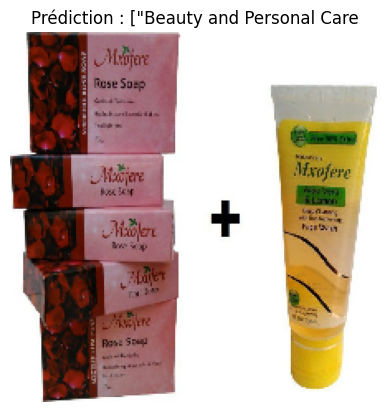

In [130]:
# Sélectionner une image de test
img_path = "Images/00d84a518e0550612fcfcba3b02b6255.jpg"  # Remplace par une image de ton dataset

def test_model(img_path) :
    # Charger et prétraiter l’image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension batch
    img_array /= 255.0  # Normalisation
    
    # Faire la prédiction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    
    # Afficher l’image avec la prédiction
    plt.imshow(img)
    plt.title(f"Prédiction : {list(test_flow.class_indices.keys())[predicted_class]}")
    plt.axis("off")
    plt.show()
test_model(img_path) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


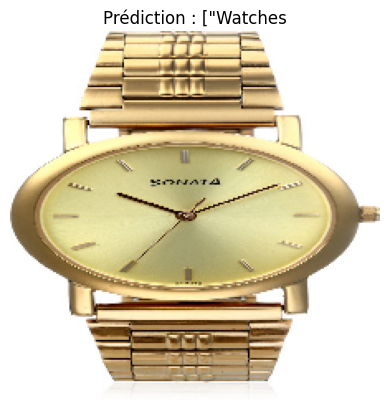

In [132]:
test_model("Images/1fcff864d6e397e1424d5366e6c6b8fa.jpg" ) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


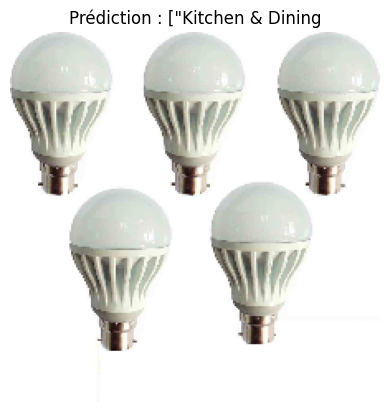

In [134]:
test_model("Images/0ca8e323551dd7107ef57ef7c3e77aee.jpg" ) 